# Bagging

Bagging is short for bootstrap aggregating.

In bagging, a model follows these constraints:

1. Same classifier
2. Train on different random subsets of the training data (with replacement).
3. You also (optionally) randomly sample on the features.


## Pasting

Pasting is a varient of bagging, the only difference is that it samples without replacement. As a consequence, with pasting, we guarentee that training instances will not be reused across predictors.

## Making a Prediction

Once each model is trained a prediction can be made from every model, and a final prediction is made using some statistical mode. In the case of classifiers, it could be a hard voting, or in the case of regression, it could be an average. The added benefit is that predictor can also be trained in parallel using CPU cores, or servers. The same could be said with prediction. For this reason, this ensemble technique tends to scale pretty well.

## Example


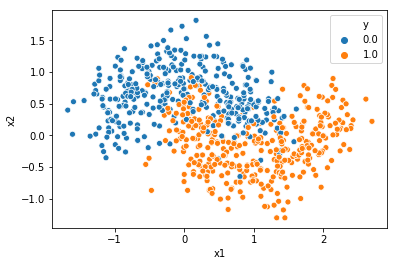

In [8]:
from sklearn.datasets import make_moons
import pandas as pd
import numpy as np

import seaborn as sns
import matplotlib.pyplot as plt


X, y = make_moons(n_samples=700, noise=.3)
df = pd.DataFrame(np.hstack((X, y.reshape((-1, 1)))), columns=['x1', 'x2', 'y'])
ax = sns.scatterplot(x="x1", y="x2", hue="y", data=df)
plt.show()

Our ensemble will feature 500 decision tree classifier, each of which that will randomly sample (with replacement i.e. `bootstrap=True`). With pasting we would otherwise set bootstrap to `False`.

In [11]:
from sklearn.model_selection import train_test_split
from sklearn.ensemble import BaggingClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.metrics import accuracy_score


X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.33, random_state=42)
bag_clf = BaggingClassifier(DecisionTreeClassifier(), n_estimators=500,
                            max_samples=100, bootstrap=True, n_jobs=-1)
bag_clf.fit(X_train, y_train)
y_pred = bag_clf.predict(X_test)
print(accuracy_score(y_test, y_pred))

0.8658008658008658


Lets visualize the decision boundary that gets made with this baggin model.

Text(0.5, 1.0, 'Decision Trees with Bagging')

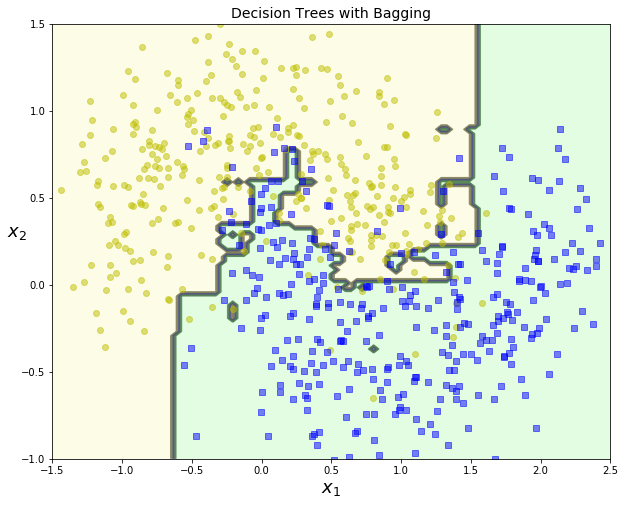

In [35]:
from myutils.draw.classification import plot_decision_boundary


plt.figure(figsize=(10,8))
plot_decision_boundary(bag_clf, X, y)
plt.title("Decision Trees with Bagging", fontsize=14)

## Out of Bag Evaluation

One of the advantage of bagging (aka bootstrapping) that that each predictor will on average only see 63% of the training instances. The remaining 37% of instances (known as the out of bag instances), can be used to validation set automatically. Each predictor can therefore evaluate its performance on the out of bag instances (which its never seen before), and the whole ensemble can therefore be evaluated by measuring its performances on the out of bag instances.

**Why is OOB 37%**

The probability of selecting a sample with replacement is $\frac{1}{n}$, therefore the probability of not selecting a sample is $1 - \frac{1}{n}$, where $n$ is the size of the dataset. Therfore not selecting a sample $n$ times in a row is $(1 - \frac{1}{n})^n$. We bootstrap $n$ times from the dataset because our goal is to get a random subset of the training set that is the same size as the original.

We can let $n$ be constant because the dataset size is fixed.

/Users/danielm/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:6: RuntimeWarning: divide by zero encountered in true_divide
  
/Users/danielm/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:6: RuntimeWarning: invalid value encountered in power
  


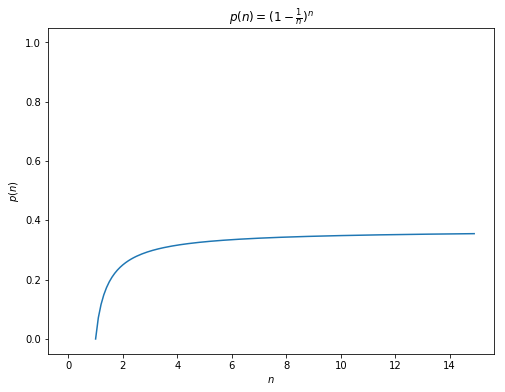

In [29]:
from myutils.draw.math import plt_2d_functions
import numpy as np
import math


plt_2d_functions([lambda n: np.power(1-1/n, n)], np.arange(0, 15, .1), fig_size=(8, 6),
                 title=r'$p(n) = (1 - \frac{1}{n})^n$', xlabel=r'$n$', ylabel=r'$p(n)$')

In [30]:
print(math.pow(1-1/1000, 1000))

0.36769542477096373


We can see that n quickly approaches 37%. We can demonstrate OOB Evaluation:

In [32]:
bag_clf = BaggingClassifier(DecisionTreeClassifier(), n_estimators=500, bootstrap=True, n_jobs=-1, oob_score=True)
bag_clf.fit(X_train, y_train)
bag_clf.oob_score_

0.906183368869936

We also have the prediction probabilities available for each predictor in the bag, depending on the bagging classifier involved. In our case, we used a decision tree, so it is made available to us.

In [34]:
bag_clf.oob_decision_function_[:4,:]

array([[0.99431818, 0.00568182],
       [0.11797753, 0.88202247],
       [0.39810427, 0.60189573],
       [1.        , 0.        ]])

## Random Patches and Random Subspaces

As discussed before, we can also randomly sample on the features in addition to the parameters. The parameters to include here are `max_features` (number of features to randomly sample), and `bootstrap_features=True`. In the case where a model ensemble both randomly samples from the training set and the features, then this is known as random patching. A random forest uses this enemble technique.

If we just randomly sample the features (`max_features=<1.0 and bootstrap_features=True)`, this is known as `random_subspaces`.


# Dicussion

**When could random sampling on the features be useful?**

There is no definite or clear answer here, but typically when the number of features are high (as in the case of images). In this general case, we randomly sample feature to trade of a high bias for a lower variance.

**Does bagging or pasting produce higher bias within a model? What is the overall trade-off between bagging and pasting?**

Bagging: Higher bias, but lower variance
Pasting: Lower bias, higher variance

Predictions from a bagging ensemble tend to be further from the truth, but they tend to be more consistent. This is because with pasting, we are guareentee to read more of the data in the sense of its uniqueness, and hence have more results closer to the truth. On the other hand, with bagging, variance tends to be lower because we bootstrap samples for each model, and as a result obtaining more consistency each of the models. This is because if there is any duplication in the data, or similier kinds of data that tend to show up more frequently - thats actually going to get replicated with higher probability with the bootstrap technique. Models tend to be more similiar with bagging.


